To summarize, the proliferation of false information on various platforms is a significant issue that can lead to social conflicts and long-lasting damage to relationships between individuals. There is ongoing research aimed at categorizing fake news.



To begin writing the code, please obtain the dataset by clicking on the provided  [link](https://drive.google.com/file/d/1q5jpI5M1EA9x3YPrLupmiu3gffkmGlHj/view).

### The sequence of actions that need to be taken.



1. Importing Libraries and Datasets
2. Data Preprocessing
3. Preprocessing and analysis of News column
4. Converting text into Vectors
5. Model training, Evaluation, and Prediction



## Importing Libraries and Datasets

* [Pandas](https://www.geeksforgeeks.org/python-pandas-dataframe/): For importing 
the dataset.
* [Seaborn](https://www.geeksforgeeks.org/introduction-to-seaborn-python/)/[Matplotlib](https://www.geeksforgeeks.org/python-introduction-matplotlib/): For data visualization.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data = pd.read_csv('/content/drive/MyDrive/Data/News.csv',index_col=0)
data.head()


,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


## Data preprocessing


In [8]:
data.shape


(44919, 5)

The title, subject, and date columns are not useful for identifying the news, therefore we can eliminate these columns.



In [9]:
data = data.drop(["title", "subject","date"], axis = 1)


Our next step is to verify the presence of any empty values and remove those rows.



In [10]:
data.isnull().sum()


text     0
class    0
dtype: int64

The dataset does not contain any empty values. To prevent bias in the model, we need to randomize the dataset, reset the index, and remove it since the index column is not relevant to us.



In [11]:
# Shuffling
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)


We will now examine the distinct values in each category using the following code.



<Axes: xlabel='class', ylabel='count'>

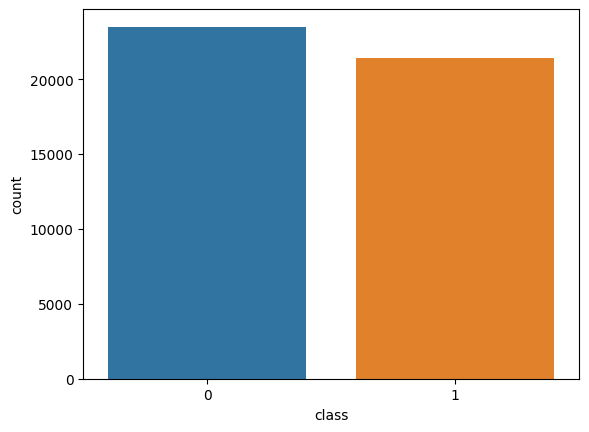

In [12]:
sns.countplot(data=data,
              x='class',
              order=data['class'].value_counts().index)


## Preprocessing and analysis of News column


Initially, we will eliminate all the stopwords, punctuation marks, and unnecessary spaces from the text. This necessitates the use of the NLTK library, and some of its modules must be downloaded. To accomplish this, execute the following code.



In [13]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


After obtaining all the necessary modules, we can generate a function called "preprocess text." This function will preprocess all the input data.



In [14]:
def preprocess_text(text_data):
    preprocessed_text = []
      
    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower()
                                  for token in str(sentence).split()
                                  if token not in stopwords.words('english')))
  
    return preprocessed_text


To apply the function to all news in the text column, execute the following command.



In [15]:
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review


100%|██████████| 44919/44919 [36:34<00:00, 20.47it/s]


We will now generate separate WordCloud visualizations for fake and real news.



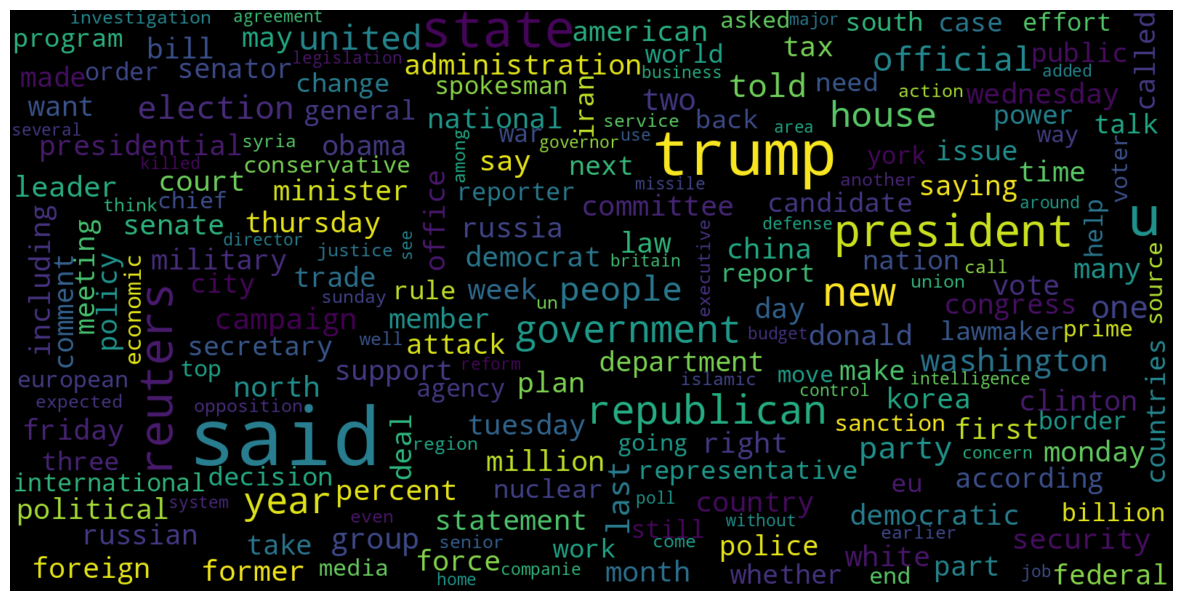

In [16]:
# Real
consolidated = ' '.join(
    word for word in data['text'][data['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()


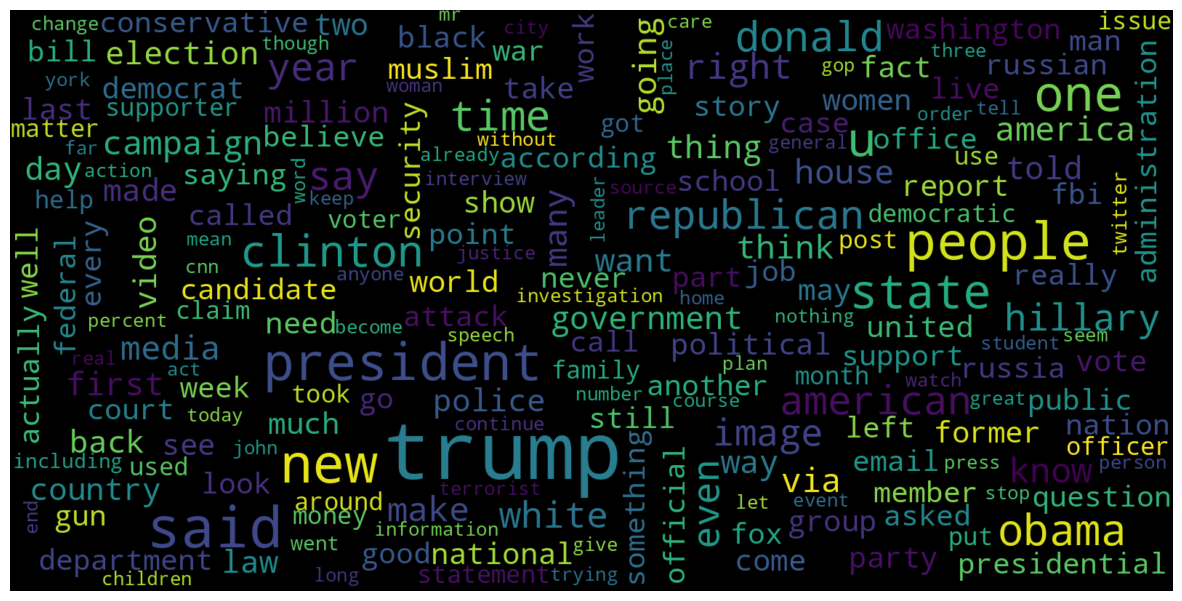

In [17]:
# Fake
consolidated = ' '.join(
    word for word in data['text'][data['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()


Next, we will create a bar graph showing the 20 most common words.



<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

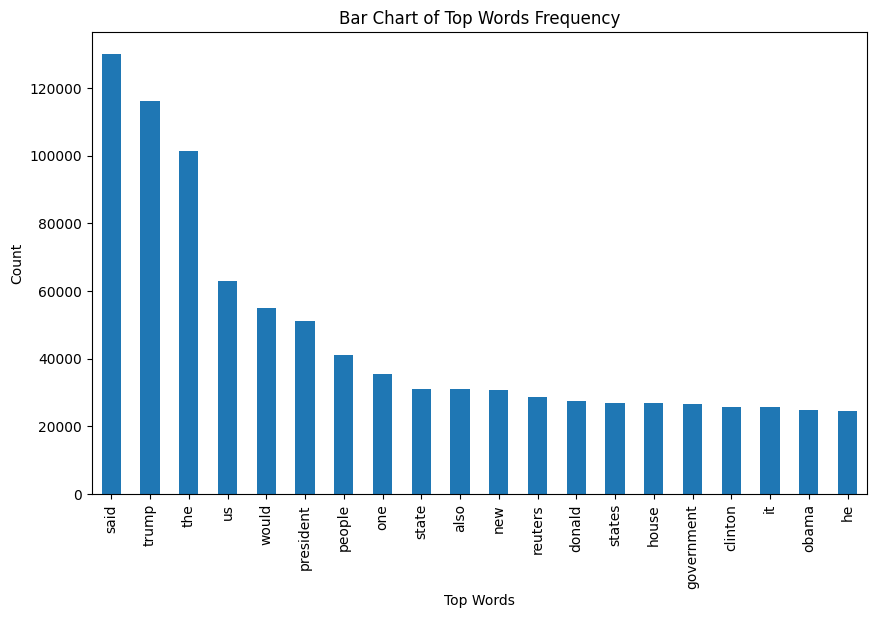

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
  
  
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]
  
  
common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])
  
df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)


## Converting text into Vectors


Prior to converting the data into vectors, divide it into training and testing sets.



In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
  
x_train, x_test, y_train, y_test = train_test_split(data['text'], 
                                                    data['class'], 
                                                    test_size=0.25)


We can now transform the training data into vectors using TfidfVectorizer.



In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
  
vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)


## Model training, Evaluation, and Prediction


The dataset is now prepared for model training.

To train the model, we will employ Logistic Regression and assess the prediction accuracy using the accuracy_score function.



In [21]:
from sklearn.linear_model import LogisticRegression
  
model = LogisticRegression()
model.fit(x_train, y_train)
  
# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))


0.9934993618094927
0.989047195013357


We will now train the model using Decision Tree Classifier.



In [22]:
from sklearn.tree import DecisionTreeClassifier
  
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
  
# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))


0.9999703167205913
0.9959928762243989


The confusion matrix for Decision Tree Classifier can be generated using the following code.



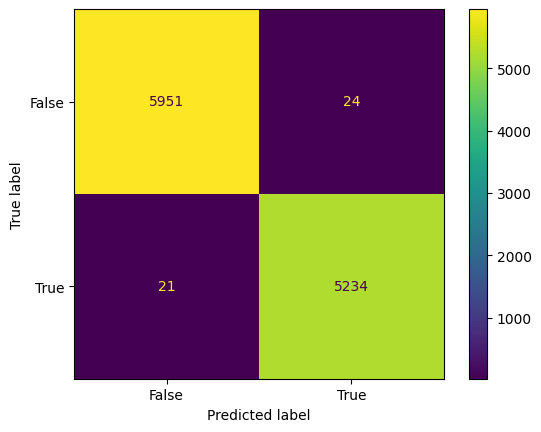

In [23]:
# Confusion matrix of Results from Decision Tree classification
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))
  
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
  
cm_display.plot()
plt.show()


## Conclusion

both Decision Tree Classifier and Logistic Regression are performing effectively.

